<a href="https://colab.research.google.com/github/VelasquezE/FourierOptics_assignments/blob/main/talleres/taller1/notebooks/taller01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importar librerías necesarias

In [168]:
import numpy as np
import cv2
import seaborn as sns
import os

import scipy.fft

from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [169]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# 1. Carga de imágenes

Se descarga la imagen cuadrada desde un repositorio de GitHub.

In [170]:
def get_image_path():
    url = "https://github.com/VelasquezE/FourierOptics_assignments/raw/d20d1cdfa4638c24c54bbebd68e6467576e05bbb/talleres/taller1/data/foto00_480_480.jpg"
    output_img = "imagen.png"

    if not os.path.exists(output_img):
        !wget -O {output_img} {url}

    img_path = os.path.abspath(output_img)
    print(f"Imagen descargada en: {img_path}")
    return img_path

In [171]:
base_path = get_image_path()

Imagen descargada en: /content/imagen.png


# 2. Procesamiento de la imagen

In [172]:
img = cv2.imread(base_path, cv2.IMREAD_GRAYSCALE)

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

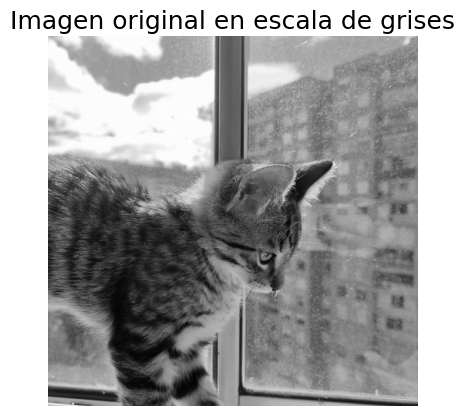

In [173]:
plt.imshow(img, cmap = "gray")
plt.title(f"Imagen original en escala de grises")
plt.axis("off")

### 2.1. Muestreo

In [174]:
def take_sample(img: np.ndarray, sample_size: int) -> np.ndarray:
    """
    Takes a sample of pixels of a picture by setting to 0
    the picture array every sample_size rows and columns.

    Parameters:
    - img (np.darray): 2d array of the picture.
    - sample_size (int): given sample size.

    Returns:
        sampled array

    """
    sample_mask = np.zeros_like(img)
    sample_mask[::sample_size, ::sample_size] = 1
    img_sample= img * sample_mask
    return img_sample

In [175]:
sample = 5
img_sample = take_sample(img, sample)

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

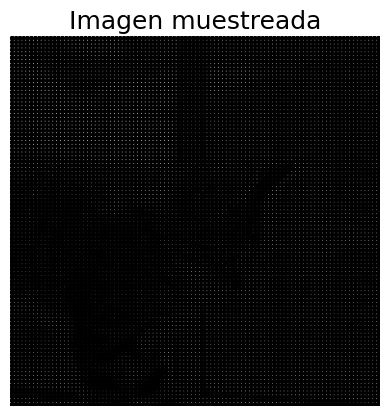

In [176]:
plt.imshow(img_sample, cmap = "gray")
plt.title(f"Imagen muestreada")
plt.axis("off")

# 3. Método 01: Transformada de Fourier

In [177]:
fourier_transform = scipy.fft.fftshift((scipy.fft.fft2(img_sample)))

visualization = np.abs(fourier_transform)

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

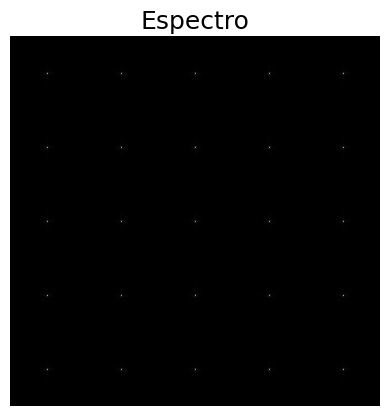

In [178]:
plt.imshow(visualization, cmap = "gray")
plt.title(f"Espectro")
plt.axis("off")

## 3.1. Aplicar filtro

### 3.1.1. Filtro cuadrado

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

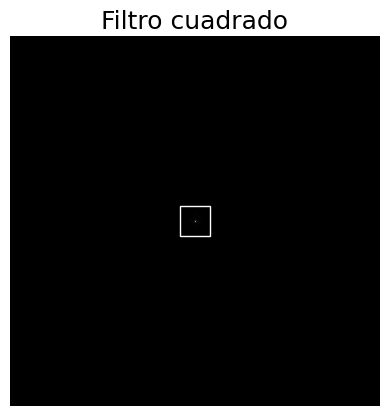

In [183]:
def create_square_mask(img: np.ndarray, sample_size: int) -> np.ndarray:
  """
  Creates an square mask with side lenght = height / sample * sample.

  Parameters:
    - img (np.darray): 2d array of the picture.
    - sample_size (int): given sample size.

  Returns:
    - square_mask (np.darray): 2d array with ones inside the
    square and zeros everywhere else.
    - square_coordinates (np.darray): array with the coordinates
    of the vertex of the square.

  """
  h, w = img.shape

  center = ((w / 2), (h / 2))

  square_side_length = h / (sample * sample)

  x1 = int(center[0] - square_side_length)
  x2 = int(center[0] + square_side_length)
  y1 = int(center[1] - square_side_length)
  y2 = int(center[1] + square_side_length)

  square_mask = np.zeros_like(fourier_transform)
  square_mask[y1:y2, x1:x2] = 1

  square_coordinates = np.array([x1, x2, y1, y2])

  return square_mask, square_coordinates

def create_square_patch(coordinates: np.ndarray):
  """
  Creates a matplotlib Rectangle from square coordinates.
  """
  x1, x2, y1, y2 = coordinates

  square_patch = patches.Rectangle(
    (x1, y1),
    x2 - x1,
    y2 - y1,
    linewidth=1,
    edgecolor='white',
    facecolor='none'
  )

  return square_patch

square_mask, square_coordinates = create_square_mask(img_sample, sample)
filtered_data = fourier_transform * square_mask

fig, ax = plt.subplots()
plt.imshow(np.abs(filtered_data), cmap = "gray")
plt.title(f"Filtro cuadrado")
square = create_square_patch(square_coordinates)
ax.add_patch(square)
plt.axis("off")

### 3.1.2. Filtro circular

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

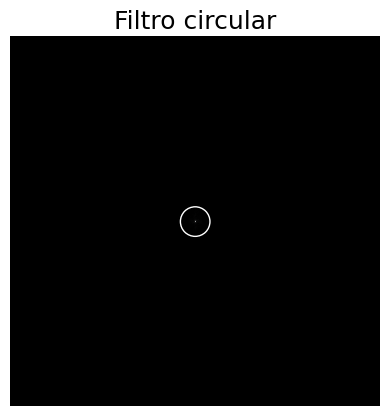

In [185]:
def create_circle_mask(img: np.ndarray, sample_size: int) -> np.ndarray:
  """
  Creates a circular mask with side radius = height / sample * sample.

  Parameters:
    - img (np.darray): 2d array of the picture.
    - sample_size (int): given sample size.

  Returns:
    - circle_mask (np.darray): 2d array with ones inside the
    circle and zeros everywhere else.
    - circle_coordinates (np.darray): array with the coordinates
    of the center and length of the radius.

  """
  h, w = img.shape

  center = ((w / 2), (h / 2))

  radius = h / (sample * sample)

  circular_mask = np.zeros_like(fourier_transform)
  Y, X = np.indices((h, w))
  mask = (np.abs(X - center[0]) <= radius) & (np.abs(Y - center[1]) <= radius)
  circular_mask[mask] = 1


  circle_coordinates = np.array([center[0], center[1], radius])

  return circular_mask, circle_coordinates

def create_circle_patch(coordinates: np.ndarray):
  """
  Creates a matplotlib Circle from square coordinates.
  """
  center_x, center_y, radius = coordinates

  circle_patch = patches.Circle(
    (center_x, center_y),
    radius,
    linewidth=1,
    edgecolor='white',
    facecolor='none'
  )

  return circle_patch

circle_mask, circle_coordinates = create_circle_mask(img_sample, sample)
filtered_data_circle = fourier_transform * circle_mask

fig, ax = plt.subplots()
plt.imshow(np.abs(filtered_data_circle), cmap = "gray")
plt.title(f"Filtro circular")
circle = create_circle_patch(circle_coordinates)
ax.add_patch(circle)
plt.axis("off")

## 3.2. Reconstrucción de la imagen aplicando la transformada de Fourier inversa

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

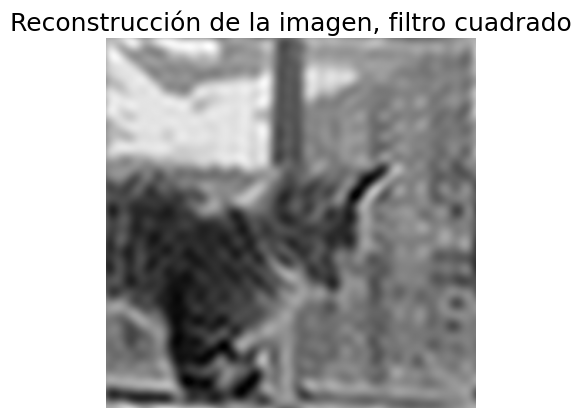

In [186]:
reconstructed_img = scipy.fft.ifft2(filtered_data)
plt.imshow(np.abs(reconstructed_img), cmap = "gray")

plt.title("Reconstrucción de la imagen, filtro cuadrado")
plt.axis("off")

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

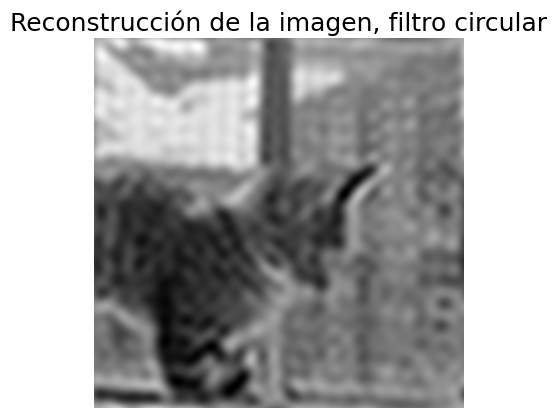

In [187]:
reconstructed_img_circle = scipy.fft.ifft2(filtered_data_circle)
plt.imshow(np.abs(reconstructed_img_circle), cmap = "gray")

plt.title("Reconstrucción de la imagen, filtro circular")
plt.axis("off")

# 4. Método 02: Convolución